Trying to replicate old code from SlowingSimulations.ipynb

10/04/21

# Set up constants, global functions etc

In [2]:
# using Revise, BeamPropagation, Distributions, StatsBase, StaticArrays, PhysicalConstants.CODATA2018, Plots, BenchmarkTools
using BeamPropagation, Distributions, PhysicalConstants.CODATA2018, StatsBase, StaticArrays, Plots, BenchmarkTools, DelimitedFiles, StructArrays

In [3]:
const h = PlanckConstant.val
const ħ = h / 2π
const λ = @with_unit 626 "nm"
const k = 2π / λ
const m = @with_unit 57 "u"
const Δv = ħ * k / m
const Γ = 1/(25e-9)
;

In [271]:
vz_μ = @with_unit 125 "m/s"
vz_σ = @with_unit 25 "m/s"
vxy_μ = @with_unit 0 "m/s"
vxy_σ = @with_unit 25 "m/s" #approximately 4 K
exit_radius = @with_unit 4 "mm"
;

In [272]:
const r = (
    Normal(0, exit_radius/2), 
    Normal(0, exit_radius/2), 
    Normal(0, 0)
)
const v = (
    Normal(vxy_μ, vxy_σ), 
    Normal(vxy_μ, vxy_σ), 
    Normal(vz_μ, vz_σ)
)
const a = (
    Normal(0, 0), 
    Normal(0, 0), 
    Normal(0, 0)
)
;

In [273]:
@inline function random_unit3Dvector()
    θ = rand(Uniform(0, 2π))
    z = rand(Uniform(-1, 1))
    return @SVector [sqrt(1-z^2)*cos(θ), sqrt(1-z^2)*sin(θ), z]
end
;

## 71cm beamline, longitudinal

In [1319]:
const detect_rad  = @with_unit 1.0 "cm"
const detect_zloc = @with_unit 71  "cm"
const detect_zlen = @with_unit 1.0 "cm"
const dead_rad = @with_unit 1.0 "cm"
const dead_len = detect_zloc + detect_zlen
;

In [1320]:
@inline function simple_prop(r, v)
    dist_detect = detect_zloc - r[3]
    x_final = r[1] + v[1] * dist_detect / v[3]
    y_final = r[2] + v[2] * dist_detect / v[3]
    return sqrt(x_final^2 + y_final^2)
end

@inline discard(r, v) = (simple_prop(r, v) > dead_rad) || (r[3] > dead_len) || (v[3] < 0)
@inline is_detectable(r) = sqrt(r[1]^2 + r[2]^2) < detect_rad && (detect_zloc + detect_zlen > r[3] > detect_zloc)

@inline function save(particles, p, s)
#     for i in 1:size(particles, 1)  
#         break
#     end
    return nothing
end
;

In [1321]:
VBRs = Weights([
    0.9457,     # to 000
    0.0447,     # 100
    3.9e-3,     # 0200
    2.7e-3,     # 200
    9.9e-4,     # 0220
    11.3e-4,    # 0110
    3.9e-4,     # 1200
    1.5e-4,     # 300
    1.3e-4,     # 1220
    0.7e-4,     # 110 (only N=1, assuming roughly 2/3 to 1/3 rotational branching)
    0.4e-4,     # 110, N=2
    5.7e-5,     # 220
    4.3e-5      # other states
])

addressed = [
    true,   # to 000
    true,   # 100
    true,   # 0200
    true,   # 200
    true,   # 0220
    true,   # 0110
    true,   # 1200
    true,   # 300
    true,   # 1220
    true,   # 110
    false,   # 110, N=2
    false,   # 220
    false   # other states
]

transverse = [
    false,  # to 000
    false,  # 100
    false,  # 0200
    false,  # 200
    false,  # 0220
    false,  # 0110
    false,  # 1200
    false,  # 300
    false,   # 1220
    false,   # 110
    false,   # 110, N=2
    false,   # 220
    false   # other states
]
;

In [1322]:
@inline function transverse_on(z)
    if 0.175 < z < 0.20     # 1st transverse region 17.5 - 20 cm after cell
        return true
    elseif 0.45 < z < 0.50  # 2nd transverse region 45 - 50 cm after cell
        return true
    elseif 0.56 < z < 0.61  # 2nd transverse region 56 - 61 cm after cell
        return true
    else
        return false
    end
end
;

In [1323]:
@inline function velocity_vector(r, v, Δvphot, p)
    
#     focus_offset = p.dcell/(p.ddet-p.dcell)*detect_zloc
#     z = r[3] + focus_offset
    
#     squared_length = r[1]^2 + r[2]^2 + z^2
    
#     x_comp = r[1] / squared_length
#     y_comp = r[2] / squared_length
#     z_comp = z / squared_length
    
#     return @SVector [v[1] - Δvphot * x_comp, v[2] - Δvphot * y_comp, v[3] - Δvphot * z_comp]
    
    return @SVector [v[1], v[2], v[3]-Δvphot]
    
end

;

In [1324]:
# the interesting physics (scattering rate vs. position, velocity etc) is contained in this function
# scattering rate expression taken from effective two-level model worked out in Mathematica notebook, plus an overall reduction factor ζ in the scattering rate
@inline function Rscatt(r,v,p)
#     vmin = -100.
#     vmax = 250.
#     if vmin < v[3]-p.voff < vmax
#         waist = beamwaist(r[3],p)
#         I0 = 2*p.power/(pi*waist^2)*1e-4 #mW/cm^2
#         Ir = I0*exp(-2*(r[1]^2+r[2]^2)/(waist^2))
#         if isnan(Ir)
#             Ir = 0
#         end
#         Rsc = p.ζ*p.Rsc_interp(v[3]-p.voff,Ir)
#     else
#         Rsc = 0.
#     end
    Rsc = 1.2e6
    return Rsc
end

@inline function update_Rsc(r, v, p)
    Rsc = Rscatt(r,v,p)
    if iszero(Rsc)
        dt = p.dt0
    else
        dt = 1/Rsc
    end
    return dt
end

;

In [1325]:
@inline function update(particles, p, s, dt)
    for i in 1:size(particles, 1)
        idx   = particles.idx[i]
        state = s.states[idx]
        
        r = particles.r[i]
        v = particles.v[i]
        
        if ~p.noslow & p.addressed[state] & (~p.transverse[state] | transverse_on(r[3]))
            state′ = sample(1:13, p.VBRs)
            v′ = @SVector [v[1], v[2], v[3] - Δv]
            v′ += Δv .* random_unit3Dvector()
            s.photons[idx] += 1
        else
            state′ = state
            v′ = v
        end
        s.states[idx] = state′
        s.rs[idx] = r
        particles.v[i] = v′
        
#         if ~p.noslow && p.addressed[state] && (~p.transverse[state] || transverse_on(r[3]))
#             dt′ = update_Rsc(r,v,p)
#             state′ = sample(1:14,p.VBRs)
#             particles.dt[i] = dt′
#             particles.use_adaptive[i] = false
#             v′ = velocity_vector(r, v, Δv, p)
#             v′ += Δv .* random_unit3Dvector()
#             s.photons[idx] += 1
#         else
#             state′ = state
#             v′ = v
#             particles.use_adaptive[i] = true
#         end
#         s.states[idx] = state′
#         s.vzs[idx] = v′[3]
#         particles.v[i] = v′
        
        if is_detectable(r) && ~s.detectable[idx]
            s.detectable[idx] = true
            s.detected_rs[idx] = r
            s.detected_states[idx] = state′
            s.vzs[idx] = v′[3]
        end
    end
    return nothing
end

@inline function f(idx, r, v, p)
    
    return SVector(0., 0., 0.)
    
end
;

In [1388]:
n = Int64(20e6)
scattering_rate = 1.0e6 #vz_μ / Δv / ((detect_zloc + 0.005) / (vz_μ / 2))
save_every = 15
delete_every = 15
dt = 1 / scattering_rate
dt_min = dt
dt_max = dt
abstol = 1e-10
max_steps = Int64(5e4)
alg = "euler"
use_adaptive = false
;

In [1389]:
vzs           = zeros(Float64, n)
photons       = zeros(Int64, n)
detectable    = zeros(Bool, n)
states        = ones(Int64, n)
detected_states = ones(Int64, n)
rs            = [SVector(0.0, 0.0, 0.0) for _ in 1:n]
detected_rs   = [SVector(0.0, 0.0, 0.0) for _ in 1:n]

noslow = false
p = @params (VBRs, transverse, addressed, noslow)
s = @params (vzs, photons, detectable, states, rs, detected_rs, detected_states)

particles = StructArray{Particle}(undef, n)

@time propagate_particles!(r, v, a, alg, particles, f, save, discard, save_every, delete_every, max_steps, update, p, s, dt, use_adaptive, dt_min, dt_max, abstol, true)

  4.505185 seconds (21.62 M allocations: 7.822 GiB, 37.34% gc time)


In [1390]:
vzs           = zeros(Float64, n)
photons       = zeros(Int64, n)
detectable    = zeros(Bool, n)
states        = ones(Int64, n)
detected_state = ones(Int64, n)
rs            = [SVector(0.0, 0.0, 0.0) for _ in 1:n]
detected_rs   = [SVector(0.0, 0.0, 0.0) for _ in 1:n]

noslow = true
p0 = @params (VBRs, transverse, addressed, noslow)
s0 = @params (vzs, photons, detectable, states, rs, detected_rs, detected_states)

particles = StructArray{Particle}(undef, n)

@time propagate_particles!(r, v, a, alg, particles, f, save, discard, save_every, delete_every, max_steps, update, p0, s0, dt, use_adaptive, dt_min, dt_max, abstol, true)

  3.142151 seconds (20.76 M allocations: 7.803 GiB, 28.06% gc time)


In [1391]:
bright = [addressed[final_state] for final_state in s.detected_states];

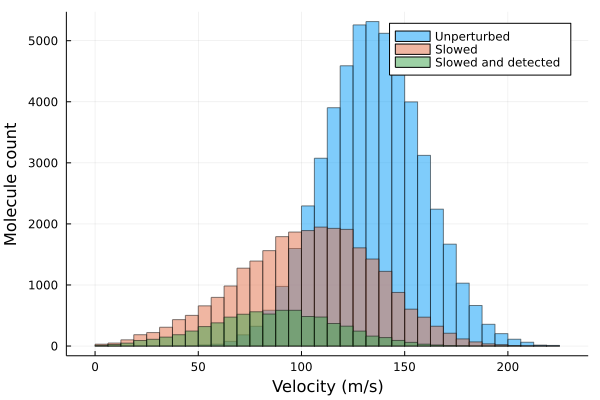

In [1392]:
barhist(s0.vzs[s0.detectable], bins=0:25/4:225, alpha=0.5, label="Unperturbed")
barhist!(s.vzs[s.detectable], bins=0:25/4:225, alpha=0.5, label="Slowed")
barhist!(s.vzs[s.detectable .& bright], bins=0:25/4:225, alpha=0.5, label="Slowed and detected")
xlabel!("Velocity (m/s)")
ylabel!("Molecule count")

In [1381]:
sum(s.vzs[s.detectable .& bright] .< 15)

46

In [1382]:
sum(s.vzs[s.detectable .& bright] .< 15) / n

2.3e-6